# Initial Setup and Data Visualization

In [1]:
!pip install windrose

In [ ]:
import numpy as np
import pylab as plt
import sys, random, os, math
sys.path.append('/mnt/d/shell/Wind Farm Evaluator/')
import Farm_Evaluator_Vec as ev
sys.path.pop()
import pandas as pd
from numba import jit, prange
from windrose import WindroseAxes                                                                                                                                                                                                                                                                                                                                                                                                                                                            
import statistics as st

In [ ]:
# A random configuration in the dataset for testing

df = pd.read_csv('/content/drive/My Drive/shell/Shell_Hackathon Dataset/turbine_loc_test.csv')
df.plot(kind = 'scatter', x = 'x', y = 'y')

In [ ]:
# Visualization of the wind data

entries =  os.scandir('/content/drive/My Drive/shell/Shell_Hackathon Dataset/Wind Data/') 
for entry in entries:
    dx = pd.read_csv(entry)

    theta = dx['drct']
    speed = dx['sped']
    ax = WindroseAxes.from_ax()                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    ax.bar(theta, speed, normed = 'true', bins=np.arange(0, 32, 2), nsector= 36)     
    ax.set_legend() 
    print(entry.name)                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    plt.show()

In [ ]:
turb_specs    =  {   
                         'Name': 'Anon Name',
                         'Vendor': 'Anon Vendor',
                         'Type': 'Anon Type',
                         'Dia (m)': 100,
                         'Rotor Area (m2)': 7853,
                         'Hub Height (m)': 100,
                         'Cut-in Wind Speed (m/s)': 3.5,
                         'Cut-out Wind Speed (m/s)': 25,
                         'Rated Wind Speed (m/s)': 15,
                         'Rated Power (MW)': 3
                  }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

power_curve   =  ev.loadPowerCurve('/mnt/d/shell/Shell_Hackathon Dataset/power_curve.csv')
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = ev.preProcessing(power_curve)

wind_inst = []
with os.scandir('/mnt/d/shell/Shell_Hackathon Dataset/Wind Data/') as entries:  
        for entry in entries:
            print(entry.name)
            wind_inst.append(ev.binWindResourceData(entry))
            


# Grid Based Hybrid Genetic Algorithm

In [ ]:
ens_N = 300
N = 50
sigma = 0.0125
s_r = 0.1
m_r = 0.001
num_steps = 2000

In [ ]:
#Grid creation and populating Ensemble
xpos = [x+50 for x in range(0, 3900, int(3900/9))]
xpos.pop()
xpos.append(3950)
norm_grid_coarse = []
for i in range(10):
    for j in range(10):
        norm_grid_coarse.append([xpos[i]/4000, xpos[j]/4000])

ens_pos = []
for xx in range(ens_N):
    L= random.sample(norm_grid_coarse, 50)    
    ens_pos.append(L)
norm_grid_coarse = np.array(norm_grid_coarse)

In [ ]:
#creating fine mesh
xpos = [x+50 for x in range(0, 3900, int(3900/2000))]
xpos.pop()
xpos.append(3950)
norm_grid_fine = []
for i in range(3900):
    for j in range(3900):
        norm_grid_fine.append([xpos[i]/4000, xpos[j]/4000])

In [ ]:
#calulation of energy of N positions of windfarms
def avg_aep(microstate):
    turb_coords = microstate * 4000
    return ev.getAEP(turb_rad, turb_coords, power_curve, wind_inst[7], 
                                         n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)  
    
# sort Ensemble with respect to the energy in decreaing order
@jit(parallel = True)
def sortby_energy(ensemble, energy_array, begin = 0, end = ens_N):
    for i in prange(begin, end):
        energy_array[i] = avg_aep(ensemble[i])
    indices = energy_array.argsort()
    ensemble = ensemble[indices[::-1]]
    return ensemble, energy_array

#select best out of the ensemble at each step
@jit(parallel = True)
def selection(ensemble, boolean_val):
    if(boolean_val):
        for i in prange(3, 50):
            indexarr = np.random.choice(len(norm_grid_coarse), size=50, replace = False)
            ensemble[i] = norm_grid_coarse[indexarr, :]
    return ensemble

@jit
def crossover(ensemble):
    for k in range(50, 300):
        indexes = np.random.choice(50, 2, replace = False)
        cross_array = np.concatenate((ensemble[indexes[0]], ensemble[indexes[1]]), axis = 0)
        cross_array = pd.DataFrame(cross_array).drop_duplicates().values
        while(True):
          indexarr = np.random.choice(len(cross_array), size=50, replace = False)
          new_contender = cross_array[indexarr, :]
          condition = True
          for i in prange(49):
              for j in range(i+1, 50):
                  min_dist_sq = ((new_contender[i][0] - new_contender[j][0]) ** 2 + (new_contender[i][1] - new_contender[j][1]) ** 2)
                  if (min_dist_sq < 0.01):
                      condition *= False
          if(condition):
            ensemble[k] = new_contender
            break
    return ensemble

@jit
def mutation(ensemble, rate):
    count1 = 1
    count2 = 1
    indexes = np.random.randint(1, ens_N, size = rate)
    for index in indexes:         
        ind = random.randint(0, 49)
        temp = ensemble[index, ind]
        rand_num = random.randint(0, 7)
        new = np.array([ensemble[index, ind, 0], ensemble[index, ind, 1]]) + local_search_array[rand_num]
        box_cond = min(new[0], new[1]) > sigma and max(new[0], new[1]) < 1.0 - sigma
        condition = True
        for i in prange(N):
            if (i != ind):      
                min_dist_sq = (new[0] - ensemble[index, i, 0])** 2 + (new[1] - ensemble[index, i, 1])** 2
                if (min_dist_sq < 0.01):
                    condition *= False
        if(condition and box_cond): 
            count2 += 1           
            ensemble[index, ind] = new
            break
        else:
            ensemble[index, ind] = temp
            break
    return ensemble, count2


In [ ]:
delta = 0.10825
local_search_array = np.array([ 
                               [-delta, delta],  [0, delta],  [delta, delta],
                               [-delta, 0],                   [delta, 0],
                               [-delta, -delta], [0, -delta], [delta, -delta]            
                                                                              ])
ensemble_of_pos = np.array(ens_pos)

overall_best_pos = np.zeros((50,2))
energy_array = np.zeros(ens_N)
enemble_average_energy = 0
overall_best_en = 50
best_to_pic = []
enerOv_to_pic = []
avgEner_arr = []
for step in range(num_steps):
    if (step%100 == 0):
        print(step, delta, overall_best_en, overall_best_pos.tolist())
    if (overall_best_en - enemble_average_energy < 0.005):
        delta *= 0.9
        local_search_array = np.array([ [-delta, delta],  [0, delta],  [delta, delta],
                                        [-delta, 0],           [delta, 0], 
                                        [-delta, -delta], [0, -delta], [delta, -delta] ])
        ensemble_of_pos, energy_array = sortby_energy(ensemble_of_pos, energy_array)
        ensemble_of_pos = selection(ensemble_of_pos, False)
    else:
        ensemble_of_pos, energy_array  = sortby_energy(ensemble_of_pos, energy_array )
        ensemble_of_pos = selection(ensemble_of_pos, False)
    ensemble_of_pos = crossover(ensemble_of_pos)
    ensemble_of_pos, energy_array  = sortby_energy(ensemble_of_pos, energy_array, begin = 50, end = 300)
    ensemble_of_pos, count_m = mutation(ensemble_of_pos, int(m_r * ens_N * N))
    enemble_average_energy = 0
    for position in ensemble_of_pos:
        zz = avg_aep(position)
        enemble_average_energy += zz   
        if (zz > overall_best_en):
            overall_best_en = zz
            overall_best_pos = position.copy()
            best_to_pic.append(overall_best_pos.tolist())
        
    enemble_average_energy = enemble_average_energy / ens_N
    avgEner_arr.append([enemble_average_energy, step]) 
    enerOv_to_pic.append([overall_best_en, step])   
    print(step, count_m, delta, enemble_average_energy, overall_best_en)



551.7759402465821
[[0.55375, 0.9875], [0.9875, 0.0125], [0.0125, 0.8785], [0.229, 0.55375], [0.229, 0.9875], [0.9875, 0.12075], [0.0125, 0.55375], [0.33725, 0.33725], [0.55375, 0.33725], [0.9875, 0.662], [0.8785, 0.0125], [0.662, 0.0125], [0.77025, 0.55375], [0.8785, 0.9875], [0.0125, 0.9875], [0.33725, 0.229], [0.4455, 0.55375], [0.662, 0.12075], [0.0125, 0.33725], [0.33725, 0.8785], [0.0125, 0.12075], [0.33725, 0.9875], [0.12075, 0.9875], [0.55375, 0.0125], [0.12075, 0.12075], [0.4455, 0.9875], [0.77025, 0.0125], [0.12075, 0.0125], [0.9875, 0.4455], [0.0125, 0.77025], [0.9875, 0.229], [0.9875, 0.33725], [0.0125, 0.662], [0.662, 0.33725], [0.662, 0.55375], [0.662, 0.77025], [0.77025, 0.9875], [0.33725, 0.0125], [0.33725, 0.55375], [0.9875, 0.9875], [0.662, 0.9875], [0.9875, 0.77025], [0.0125, 0.0125], [0.0125, 0.4455], [0.9875, 0.55375], [0.229, 0.0125], [0.55375, 0.55375], [0.4455, 0.0125], [0.9875, 0.8785], [0.12075, 0.55375]]
Both perimeter and proximity constraints are satisfied !

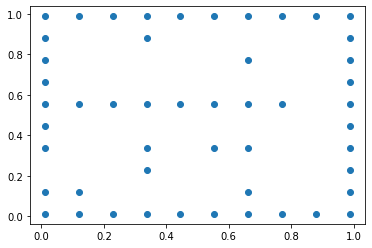

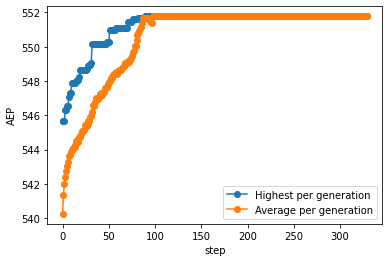

In [ ]:
print(overall_best_en)
print(overall_best_pos.tolist())

new11 = overall_best_pos*4000
ev.checkConstraints(new11, turb_diam)

plt.scatter(*zip(*overall_best_pos)) 
plt.show()

plt.xlabel('step')
plt.ylabel('AEP')
y, x = zip(*enerOv_to_pic)
plt.plot(x, y, 'o-', label = 'Highest per generation')
plt.savefig('overall_energy_step')

y, x = zip(*avgEner_arr)
plt.plot(x, y, 'o-', label = 'Average per generation')
plt.legend()
plt.savefig('average_energy_step')

In [ ]:
xyz = overall_best_pos*4000
df = pd.DataFrame(xyz)
df.to_csv('submit.csv', index=False, header=False)

# Reduced Dimension Version of GA for Faster Results

In [ ]:
# parameters

ens_N = 2000
N = 14                  # excluding the turbines at boundary
sigma = 0.1125
m_r = 0.1
num_steps = 2000

In [ ]:
#Grid creation and populating Ensemble
xpos = [x+450 for x in range(0, 3100, int(3100/7))]
xpos.pop()
xpos.append(3550)
norm_grid_coarse = []
for i in range(8):
    for j in range(8):
        norm_grid_coarse.append([xpos[i]/4000, xpos[j]/4000])

ens_pos = []
for xx in range(ens_N):
    L= random.sample(norm_grid_coarse, N)    
    ens_pos.append(L)
norm_grid_coarse = np.array(norm_grid_coarse)

In [ ]:
#creating fine mesh
xpos = [x+450 for x in range(0, 3100, int(3100/2000))]
xpos.pop()
xpos.append(3950)
norm_grid_fine = []
for i in range(len(xpos)):
    for j in range(len(xpos)):
        norm_grid_fine.append([xpos[i]/4000, xpos[j]/4000])


In [ ]:

#calulation of energy of N positions of windfarms

boundary_positions = np.array([[0.9875, 0.0125], [0.0125, 0.9875], [0.77025, 0.9875], [0.9875, 0.9875], [0.9866496781493791, 0.769399678149379],
                                [0.9875, 0.8785], [0.4455, 0.0125], [0.12075, 0.0125], [0.0125, 0.662], [0.9875, 0.229], [0.33725, 0.0125],
                                [0.229, 0.9875], [0.55375, 0.0125], [0.8785, 0.0125], [0.55375, 0.9875], [0.0125, 0.55375], [0.229, 0.0125], 
                                [0.33725, 0.9875], [0.9875, 0.662], [0.7692844171348504, 0.013013686970533804], [0.12075, 0.9875], [0.0125, 0.8785],
                                [0.8785, 0.9875], [0.013002106549573164, 0.22849789345042684], [0.0125, 0.0125], [0.662, 0.9875], [0.9875, 0.33725],
                                [0.662, 0.0125], [0.9875, 0.12075], [0.0125, 0.4455], [0.9875, 0.4455], [0.4455, 0.9875], [0.0125, 0.33725], 
                                [0.9875, 0.55375], [0.013350321850620947, 0.77025], [0.0125, 0.12075]])

def avg_aep(microstate):  
    turb_coords = np.concatenate((microstate, boundary_positions), axis = 0)
    turb_coords = turb_coords * 4000
    return ev.getAEP(turb_rad, turb_coords, power_curve, wind_inst[0], 
                                         n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)  
    
# sort Ensemble with respect to the energy in decreaing order
@jit(parallel = True)
def sortby_energy(ensemble, energy_array, begin = 0, end = ens_N):
    for i in prange(begin, end):
        energy_array[i] = avg_aep(ensemble[i])
    indices = energy_array.argsort()
    ensemble = ensemble[indices[::-1]]
    return ensemble, energy_array

#select best out of the ensemble at each step
@jit(parallel = True)
def selection(ensemble, boolean_val):
    if(boolean_val):
        for i in prange(3, 100):
            indexarr = np.random.choice(len(norm_grid_coarse), size=N, replace = False)
            ensemble[i] = norm_grid_coarse[indexarr, :]
    return ensemble

@jit
def crossover(ensemble):
    for k in range(100, ens_N):
        indexes = np.random.choice(100, 2, replace = False)
        cross_array = np.concatenate((ensemble[indexes[0]], ensemble[indexes[1]]), axis = 0)
        cross_array = pd.DataFrame(cross_array).drop_duplicates().values
        while(True):
          indexarr = np.random.choice(len(cross_array), size=N, replace = False)
          new_contender = cross_array[indexarr, :]
          condition = True
          for i in prange(N-1):
              for j in range(i+1, N):
                  min_dist_sq = ((new_contender[i][0] - new_contender[j][0]) ** 2 + (new_contender[i][1] - new_contender[j][1]) ** 2)
                  if (min_dist_sq < 0.01):
                      condition *= False
          if(condition):
            ensemble[k] = new_contender
            break
    return ensemble

@jit
def mutation(ensemble, rate):
    count1 = 1
    count2 = 1
    indexes = np.random.randint(1, ens_N, size = rate)
    for index in indexes:
        while(True):           
            ind = random.randint(0, N-1)
            temp = ensemble[index, ind]
            ran_num = random.uniform(0, 1)
            if (ran_num < 0.5):
                new = norm_grid_fine[np.random.randint(0, 3100*3100)]
                condition = True
                for i in prange(N):
                    if (i != ind):      
                        min_dist_sq = (new[0] - ensemble[index, i, 0])** 2 + (new[1] - ensemble[index, i, 1])** 2
                        if (min_dist_sq < 0.01):
                            condition *= False
                if(condition):
                    count1 += 1
                    ensemble[index, ind] = new
                    break

            else:
                rand_num = random.randint(0, 7)
                new = np.array([ensemble[index, ind, 0], ensemble[index, ind, 1]]) + local_search_array[rand_num]
                box_cond = min(new[0], new[1]) > sigma and max(new[0], new[1]) < 1.0 - sigma
                condition = True
                for i in prange(N):
                    if (i != ind):      
                        min_dist_sq = (new[0] - ensemble[index, i, 0])** 2 + (new[1] - ensemble[index, i, 1])** 2
                        if (min_dist_sq < 0.01):
                            condition *= False
                if(condition and box_cond): 
                    count2 += 1           
                    ensemble[index, ind] = new
                    break
    return ensemble, count1/(count1+count2)


In [ ]:
delta = 0.1105
local_search_array = np.array([ 
                               [-delta, delta],  [0, delta],  [delta, delta],
                               [-delta, 0],                   [delta, 0],
                               [-delta, -delta], [0, -delta], [delta, -delta]            
                                                                              ])
ensemble_of_pos = np.array(ens_pos)
overall_best_pos = np.zeros((N,2))
energy_array = np.zeros(ens_N)
enemble_average_energy = 0
overall_best_en = 50
for step in range(num_steps):
    if (step%100 == 0):
        zz_z = np.concatenate((overall_best_pos, boundary_positions), axis = 0)
        print(step, delta, overall_best_en, zz_z.tolist())
    if (overall_best_en - enemble_average_energy < 0.05):
        delta *= 0.99
        local_search_array = np.array([ [-delta, delta],  [0, delta],  [delta, delta],
                                        [-delta, 0],           [delta, 0], 
                                        [-delta, -delta], [0, -delta], [delta, -delta] ])
        ensemble_of_pos, energy_array = sortby_energy(ensemble_of_pos, energy_array)
        ensemble_of_pos = selection(ensemble_of_pos, True)
        zz_z = np.concatenate((overall_best_pos, boundary_positions), axis = 0)
        print('#', step, delta, overall_best_en, zz_z.tolist())
    else:
        ensemble_of_pos, energy_array  = sortby_energy(ensemble_of_pos, energy_array )
        ensemble_of_pos = selection(ensemble_of_pos, False)
    ensemble_of_pos = crossover(ensemble_of_pos)
    ensemble_of_pos, energy_array  = sortby_energy(ensemble_of_pos, energy_array, begin = 100, end = ens_N)
    ensemble_of_pos, count_m = mutation(ensemble_of_pos, int(m_r * ens_N * N))
    enemble_average_energy = 0
    for position in ensemble_of_pos:
        zz = avg_aep(position)
        enemble_average_energy += zz   
        if (zz > overall_best_en):
            overall_best_en = zz
            overall_best_pos = position.copy() 
        
    enemble_average_energy = enemble_average_energy / ens_N
        
    print(step, count_m, delta, enemble_average_energy, overall_best_en)



, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.9875, 0.0125], [0.0125, 0.9875], [0.77025, 0.9875], [0.9875, 0.9875], [0.9866496781493791, 0.769399678149379], [0.9875, 0.8785], [0.4455, 0.0125], [0.12075, 0.0125], [0.0125, 0.662], [0.9875, 0.229], [0.33725, 0.0125], [0.229, 0.9875], [0.55375, 0.0125], [0.8785, 0.0125], [0.55375, 0.9875], [0.0125, 0.55375], [0.229, 0.0125], [0.33725, 0.9875], [0.9875, 0.662], [0.7692844171348504, 0.013013686970533804], [0.12075, 0.9875], [0.0125, 0.8785], [0.8785, 0.9875], [0.013002106549573164, 0.22849789345042684], [0.0125, 0.0125], [0.662, 0.9875], [0.9875, 0.33725], [0.662, 0.0125], [0.9875, 0.12075], [0.0125, 0.4455], [0.9875, 0.4455], [0.4455, 0.9875], [0.0125, 0.33725], [0.9875, 0.55375], [0.013350321850620947, 0.77025], [0.0125, 0.12075]]
0 0.4985754985754986 0.1105 551.373747662201 553.3006796264649
1 0.4672364672364672 0.1105 552.0837654382326 553.4176048278808
2 0.48860398

KeyboardInterrupt: 

557.1266967773438
[[0.577, 0.82825], [0.83925, 0.19875], [0.3895, 0.40175], [0.198, 0.1625], [0.27525, 0.6165], [0.28, 0.40125], [0.3175, 0.119], [0.60475, 0.61025], [0.71475, 0.3915], [0.8815, 0.6805], [0.6065, 0.3975], [0.25475, 0.745], [0.389, 0.7195], [0.49600000000000005, 0.3975], [0.9875, 0.0125], [0.0125, 0.9875], [0.77025, 0.9875], [0.9875, 0.9875], [0.9866496781493791, 0.769399678149379], [0.9875, 0.8785], [0.4455, 0.0125], [0.12075, 0.0125], [0.0125, 0.662], [0.9875, 0.229], [0.33725, 0.0125], [0.229, 0.9875], [0.55375, 0.0125], [0.8785, 0.0125], [0.55375, 0.9875], [0.0125, 0.55375], [0.229, 0.0125], [0.33725, 0.9875], [0.9875, 0.662], [0.7692844171348504, 0.013013686970533804], [0.12075, 0.9875], [0.0125, 0.8785], [0.8785, 0.9875], [0.013002106549573164, 0.22849789345042684], [0.0125, 0.0125], [0.662, 0.9875], [0.9875, 0.33725], [0.662, 0.0125], [0.9875, 0.12075], [0.0125, 0.4455], [0.9875, 0.4455], [0.4455, 0.9875], [0.0125, 0.33725], [0.9875, 0.55375], [0.01335032185062094

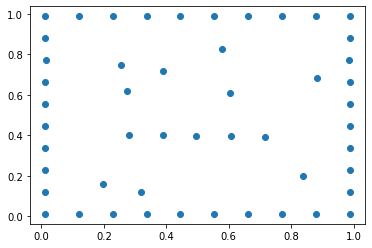

In [ ]:
zz_z1 = np.concatenate((overall_best_pos, boundary_positions), axis = 0)
print(overall_best_en)
print(zz_z1.tolist())

new11 = zz_z1*4000
ev.checkConstraints(new11, turb_diam)

plt.scatter(*zip(*zz_z1)) 
plt.show()

In [ ]:
xyz = overall_best_pos*4000
df = pd.DataFrame(xyz)
df.to_csv('submit.csv', index=False, header=False)

# Simulated Annealing

In [ ]:
#simulated annealing optimizer
import matplotlib.pyplot as plt 
import random, math
import numpy as np
import pandas as pd
import os
import sys
sys.path.append('/content/drive/My Drive/shell/Wind Farm Evaluator/')
import Farm_Evaluator_Vec as ev
sys.path.pop()
from operator import itemgetter

turb_specs    =  {   
                         'Name': 'Anon Name',
                         'Vendor': 'Anon Vendor',
                         'Type': 'Anon Type',
                         'Dia (m)': 100,
                         'Rotor Area (m2)': 7853,
                         'Hub Height (m)': 100,
                         'Cut-in Wind Speed (m/s)': 3.5,
                         'Cut-out Wind Speed (m/s)': 25,
                         'Rated Wind Speed (m/s)': 15,
                         'Rated Power (MW)': 3
                  }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

power_curve   =  ev.loadPowerCurve('/content/drive/My Drive/shell/Shell_Hackathon Dataset/power_curve.csv')
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = ev.preProcessing(power_curve)

wind_inst = []
with os.scandir('/content/drive/My Drive/shell/Shell_Hackathon Dataset/Wind Data/') as entries:  
        for entry in entries:
            print(entry.name)
            wind_inst.append(ev.binWindResourceData(entry))

def avg_aep(L):
    turb_coords = np.array([[i*4000, j*4000] for i, j in L])
    return - ev.getAEP(turb_rad, turb_coords, power_curve, wind_inst[0], 
                                         n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)

wind_data_2007.csv
wind_data_2013.csv
wind_data_2008.csv
wind_data_2009.csv
wind_data_2014.csv
wind_data_2017.csv
wind_data_2015.csv
2017_2007.csv
2017_2007_2008.csv


In [ ]:
#beta * 1.005
# n acc = 200
#delta = .005
# do sa for 14 inner
#-549.7850706481934
L = [[0.4455, 0.55375], [0.12075, 0.9875], [0.0125, 0.0125], [0.0125, 0.662], [0.9875, 0.8785], [0.55375, 0.33725], [0.8785, 0.9875], [0.4455, 0.0125], [0.0125, 0.9875], [0.0125, 0.55375], [0.229, 0.9875], [0.55375, 0.9875], [0.9875, 0.9875], [0.229, 0.55375], [0.33725, 0.9875], [0.33725, 0.0125], [0.4455, 0.9875], [0.0125, 0.4455], [0.0125, 0.33725], [0.662, 0.0125], [0.9875, 0.0125], [0.55375, 0.0125], [0.662, 0.33725], [0.9875, 0.55375], [0.0125, 0.8785], [0.9875, 0.229], [0.8785, 0.229], [0.9875, 0.4455], [0.8785, 0.8785], [0.33725, 0.33725], [0.662, 0.77025], [0.77025, 0.0125], [0.9875, 0.33725], [0.9875, 0.12075], [0.9875, 0.662], [0.9875, 0.77025], [0.33725, 0.55375], [0.662, 0.9875], [0.662, 0.55375], [0.8785, 0.0125], [0.0125, 0.77025], [0.77025, 0.9875], [0.0125, 0.229], [0.44549999999999995, 0.33725], [0.12075, 0.0125], [0.0125, 0.12075], [0.229, 0.77025], [0.77025, 0.55375], [0.55375, 0.77025], [0.229, 0.0125]]

best_fit = [[0.4455, 0.55375], [0.12075, 0.9875], [0.0125, 0.0125], [0.0125, 0.662], [0.9875, 0.8785], [0.55375, 0.33725], [0.8785, 0.9875], [0.4455, 0.0125], [0.0125, 0.9875], [0.0125, 0.55375], [0.229, 0.9875], [0.55375, 0.9875], [0.9875, 0.9875], [0.229, 0.55375], [0.33725, 0.9875], [0.33725, 0.0125], [0.4455, 0.9875], [0.0125, 0.4455], [0.0125, 0.33725], [0.662, 0.0125], [0.9875, 0.0125], [0.55375, 0.0125], [0.662, 0.33725], [0.9875, 0.55375], [0.0125, 0.8785], [0.9875, 0.229], [0.8785, 0.229], [0.9875, 0.4455], [0.8785, 0.8785], [0.33725, 0.33725], [0.662, 0.77025], [0.77025, 0.0125], [0.9875, 0.33725], [0.9875, 0.12075], [0.9875, 0.662], [0.9875, 0.77025], [0.33725, 0.55375], [0.662, 0.9875], [0.662, 0.55375], [0.8785, 0.0125], [0.0125, 0.77025], [0.77025, 0.9875], [0.0125, 0.229], [0.44549999999999995, 0.33725], [0.12075, 0.0125], [0.0125, 0.12075], [0.229, 0.77025], [0.77025, 0.55375], [0.55375, 0.77025], [0.229, 0.0125]]


N = 50
sigma = 0.0125
beta = 1
n_accept = 0
best_energy = avg_aep(L)
n_steps = 5000000

best_to_pic = []
ener_to_pic = []
energy =  avg_aep(L)
for step in range(n_steps):
    if n_accept == 2500:
        beta *=  1.005
        n_accept = 0
    
    if(random.uniform(0,1) < 0.28):
        #for  inner ones
        delta = 0.01
        a = random.choice(L[:14])
        b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
        min_dist_sq = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a) 
        # make it 8 sigma
        box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
        if not (box_cond or min_dist_sq < 0.01):
            a[:] = b         
    else:
        #for  boundary ones
        delta = 0.0025
        a = random.choice(L[14:])
        b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
        min_dist_sq = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a) 
        # make it 8 sigma
        box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
        if not (box_cond or min_dist_sq < 0.01):
            a[:] = b  

    new_energy = avg_aep(L)
    if random.uniform(0.0, 1.0) < math.exp( - beta * (new_energy - energy)):
        n_accept += 1
        energy = new_energy
        if energy < best_energy:
           best_energy = energy
           best_fit = [[L[x][y] for y in range(len(L[0]))] for x in range(len(L))]
           best_to_pic.append(best_fit)
           ener_to_pic.append([best_energy, step])
           print('###', best_energy, best_fit)
    else:
        L = [[best_fit[x][y] for y in range(len(best_fit[0]))] for x in range(len(best_fit))]
    if step % 1000 == 0:
        print (step, 1.0 / beta, best_energy)

print(best_energy)

0 1.0 -552.1507424926758
### -552.150876159668 [[0.4493357797402937, 0.5542539412905823], [0.12075, 0.9875], [0.0125, 0.0125], [0.0125, 0.662], [0.9875, 0.8785], [0.55375, 0.33725], [0.8785, 0.9875], [0.4455, 0.0125], [0.0125, 0.9875], [0.0125, 0.55375], [0.229, 0.9875], [0.55375, 0.9875], [0.9875, 0.9875], [0.229, 0.55375], [0.33725, 0.9875], [0.33725, 0.0125], [0.4455, 0.9875], [0.0125, 0.4455], [0.0125, 0.33725], [0.662, 0.0125], [0.9875, 0.0125], [0.55375, 0.0125], [0.662, 0.33725], [0.9875, 0.55375], [0.0125, 0.8785], [0.9875, 0.229], [0.8781774178485693, 0.22938867244489194], [0.9875, 0.4455], [0.8785, 0.8785], [0.33511713245729136, 0.33590466801605284], [0.662, 0.77025], [0.77025, 0.0125], [0.9875, 0.33725], [0.9875, 0.12075], [0.9869740557488764, 0.6632845067434183], [0.9875, 0.77025], [0.33725, 0.55375], [0.662, 0.9875], [0.662, 0.55375], [0.8785, 0.0125], [0.0125, 0.77025], [0.77025, 0.9875], [0.0125, 0.229], [0.44790197361651035, 0.3355294926418746], [0.12075, 0.0125], [0.01

KeyboardInterrupt: ignored

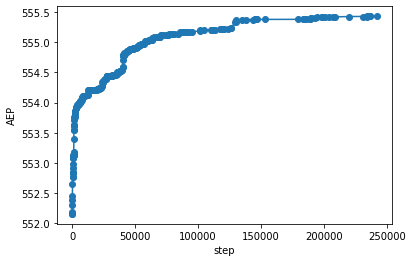

In [ ]:
plt.xlabel('step')
plt.ylabel('AEP')
y, x = zip(*ener_to_pic)
plt.plot(x, y, 'o-')
plt.savefig('simann_energy_step')

In [ ]:
plt.scatter(*zip(*best_fit)) 
plt.show()

In [ ]:
new11 = [[x*4000, y*4000] for x, y in best_fit]
ev.checkConstraints(new11, turb_diam)

In [ ]:
xyz = np.array([[i*4000, j*4000] for i, j in best_fit])
df = pd.DataFrame(xyz)
df.to_csv('file3_new.csv', index=False, header=False)